In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.io import fits

In [29]:
FILEPATH="F:\Masters Project Data\\alienworlds_data\\"
hdu = fits.open(FILEPATH+"kplr002715135-20160128150956_dvt.fits")
phase1=hdu[1].data['PHASE']
flux1=hdu[1].data['LC_DETREND']
phase2=hdu[4].data['PHASE']
flux2=hdu[4].data['LC_DETREND']
print(hdu[1].header['TDUR'],hdu[1].header['TDEPTH'],hdu[1].header['TPERIOD'])
print(hdu[4].header['TDUR'],hdu[4].header['TDEPTH'],hdu[4].header['TPERIOD'])
#print(hdu[1].header)

1.9677450171696718 821.3687919214366 5.747708928748721
12.91885581086741 733.2243248908284 319.42543597478107


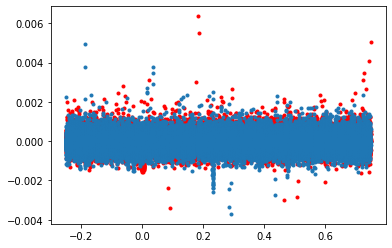

In [30]:
#okay, immediate problems... we HAVE TO REBIN. To do that if we end up taking median flux, then that's a major distortion
#for transits with multiple planets. If we don't, we may end up with variable bins... so thats not possible either. We'll 
#follow through with this right now, along the road of Shallue and Vandenberg(global view), but some jugaad is pending...
#assuming for now different TCE headers will end up with different events separated, but that may not be the case.
period1=hdu[1].header['TPERIOD']
period2=hdu[4].header['TPERIOD']
plt.plot(phase1/period1,flux1,marker='.',ls='none',color='red')
plt.plot(phase2/period2,flux2,marker='.',ls='none')
#plt.xlim(-2,2)
plt.show()

In [81]:
#we'll take one TCE per data set right now, but some generalisation is pending... or else stuff can get pretty bizarre
#here we try to rebin the data... set up a fixed number of input nodes maybe? Lets take a ballpark number to start with,
#say 1000 in global view 100 in local view?
#empty bins is a major problem
#shallue and vandenberg have normalised their LCs x-axis to 1. Good idea for the neural network, VERY BAD IDEA FOR THE FALSE POSITIVES.
#thats why their false positives detections were so messed up...

GLOBAL_VIEW=1000
LOCAL_VIEW=100
def rebin(x,y,tr_dur):
    tr_dur=tr_dur/24
    tempx=[]
    tempy=[]
    for i in range(0,len(y)):
        if(not np.isnan(y[i])):
            tempx.append(x[i])
            tempy.append(y[i])
    x=tempx
    y=tempy
    df = pd.DataFrame(list(zip(x, y)),columns =['phase', 'flux'])
    
    low=x[np.argmin(x)]
    high=x[np.argmax(x)]
    bins=np.linspace(low,high,GLOBAL_VIEW)
    bins_lc=np.linspace(-tr_dur,tr_dur,LOCAL_VIEW+1)

    groups = df.groupby(np.digitize(df['phase'], bins))
    df_gl=groups.mean()
    
    tot=pd.Series(np.arange(0,GLOBAL_VIEW))
    left=tot.index.difference(df_gl.index)
    #print(left)
    for el in left:
        if (el==0 or el==GLOBAL_VIEW): continue
        i=1
        while el-i in left or el+i in left:
            if (el-i==0 or el+i==GLOBAL_VIEW): break
            i=i+1
        if (el-i==0 or el+i==GLOBAL_VIEW): continue
        df_gl.loc[el]=[(df_gl.loc[el-i]['phase']+df_gl.loc[el+i]['phase'])/2,(df_gl.loc[el-i]['flux']+df_gl.loc[el+i]['flux'])/2]
    df_gl=df_gl.sort_index(axis=0)

    df_lc=df[(df["phase"] > -tr_dur) & (df["phase"] < tr_dur)]
    lc_groups = df_lc.groupby(np.digitize(df_lc['phase'], bins_lc))
    df_lc_f=lc_groups.mean()

    tot=pd.Series(np.arange(0,LOCAL_VIEW))
    left=tot.index.difference(df_lc_f.index)
    #print(left)
    for el in left:
        if (el==0 or el==LOCAL_VIEW): continue
        i=1
        while el-i in left or el+i in left:
            if (el-i==0 or el+i==LOCAL_VIEW): break
            i=i+1
        if (el-i==0 or el+i==LOCAL_VIEW): continue
        df_lc_f.loc[el]=[(df_lc_f.loc[el-i]['phase']+df_lc_f.loc[el+i]['phase'])/2,(df_lc_f.loc[el-i]['flux']+df_lc_f.loc[el+i]['flux'])/2]
    df_lc_f=df_lc_f.sort_index(axis=0)

    #print(len(df_lc_f),len(df_gl))
    #plt.plot(df_gl['phase'],df_gl['flux'],marker='.',ls='none')
    #plt.plot(df_lc_f['phase'],df_lc_f['flux'],marker='.',ls='none')
    #plt.xlim(-1,1)
    return (df_lc_f,df_gl)


#rebin(phase2,flux2,hdu[4].header['TDUR'])
#rebin(phase1,flux1,hdu[1].header['TDUR'])


In [82]:
#in this section we run the loop for bringing sample out of database and write it into a matrix
#this matrix is gonna be our training sample
FILEPATH="F:\Masters Project Data\\alienworlds_data\\"
entries=os.scandir("F:\Masters Project Data\\alienworlds_data\\")
x=0
for el in entries:
    hdu = fits.open(FILEPATH+el.name)
    n=len(hdu)
    x=x+1
    # if(x==30): break
    for i in range(1,n-1):
        if(hdu[i].header['TDUR']==None): continue
        phase=hdu[i].data['PHASE']
        period=hdu[i].data['TPERIOD']
        flux=hdu[i].data['LC_DETREND']
        df_lc,df_gl=rebin(phase/tperiod,flux,hdu[i].header['TDUR'])
        df_lc.to_csv('data_red/local/'+el.name[4:13]+'_'+str(i)+'_l',sep=' ',index=False)
        df_gl.to_csv('data_red/global/'+el.name[4:13]+'_'+str(i)+'_g',sep=' ',index=False)
        print(x,len(df_gl),len(df_lc))
        #print(hdu[1].header['TDUR'],hdu[1].header['TDEPTH'],hdu[1].header['TPERIOD'])
        #print(hdu[2].header['TDUR'],hdu[2].header['TDEPTH'],hdu[1].header['TPERIOD'])

1 1000 100
2 1000 100
2 1000 100
3 1000 100
3 1000 100
3 1000 100
4 1000 100
4 1000 100
5 1000 100
6 1000 100
7 1000 100
7 1000 100
8 1000 100
9 1000 100
9 1000 98
10 1000 100
10 1000 100
11 1000 100
12 1000 100
12 1000 100
13 1000 100
13 1000 100
14 1000 100
15 1000 100
15 1000 100
16 1000 100
16 1000 100
17 1000 100
18 1000 100
19 1000 100
20 1000 100
21 1000 100
22 1000 100
23 1000 100
23 1000 100
24 1000 100
25 1000 100
26 1000 100
26 1000 100
27 1000 100
28 1000 100
29 1000 100
29 1000 100
29 1000 99
29 1000 100
30 1000 100
30 1000 100
31 1000 100
31 1000 99
32 1000 100
33 1000 100
34 1000 100
34 1000 100
35 1000 100
36 1000 98
37 1000 100
37 1000 100
38 1000 100
38 1000 100
39 1000 99
39 1000 100
40 1000 100
41 1000 100
42 1000 100
42 1000 100
43 1000 100
44 1000 100
45 1000 100
46 1000 100
47 1000 100
48 1000 100
49 1000 100
50 1000 100
51 1000 100
52 1000 100
53 1000 100
53 1000 100
53 1000 100
54 1000 100
54 1000 99
54 1000 100
55 1000 100
55 1000 100
55 1000 100
55 1000 100
5

    Header size is not multiple of 2880: 6711176
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


1415 1000 100
1415 1000 100
1416 1000 98
1417 1000 100
1418 1000 100
1419 1000 100
1419 1000 100
1420 1000 100
1421 1000 100
1421 1000 100
1421 1000 100
1422 1000 100
1422 1000 98
1423 1000 100
1424 1000 92
1425 1000 100
1426 1000 100
1426 1000 96
1426 1000 91
1427 1000 100
1427 1000 100
1428 1000 100
1428 1000 100
1428 1000 100
1429 1000 100
1430 1000 100
1431 1000 100
1432 1000 100
1433 1000 100
1434 1000 100
1435 1000 100
1435 1000 100
1436 1000 98
1436 1000 100
1437 1000 100
1438 1000 100
1439 1000 100
1440 1000 100
1440 1000 100
1441 1000 100
1442 1000 100
1442 1000 100
1442 1000 100
1443 1000 100
1444 1000 100
1444 1000 100
1445 1000 100
1446 1000 100
1447 1000 100
1448 1000 100
1448 1000 100
1449 1000 100
1450 1000 100
1450 1000 100
1451 1000 100
1452 1000 100
1453 1000 100
1454 1000 100
1455 1000 100
1456 1000 100
1456 1000 100
1456 1000 100
1457 1000 100
1458 1000 100
1459 1000 100
1459 1000 100
1460 1000 100
1460 1000 100
1461 1000 100
1461 1000 100
1461 1000 100
1462 1000 10

    Header size is not multiple of 2880: 5454456
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


1562 1000 100
1563 1000 100
1564 1000 100
1564 1000 100
1564 1000 100
1565 1000 100
1566 1000 100
1567 1000 100
1568 1000 100
1568 1000 100
1569 1000 100
1570 1000 100
1570 1000 100
1571 1000 100
1572 1000 100
1573 1000 100
1574 1000 100
1575 1000 100
1576 1000 100
1577 1000 100
1577 1000 100
1577 1000 100
1577 1000 100
1577 1000 100
1577 1000 100
1578 1000 100
1579 1000 100
1580 1000 100
1581 1000 100
1582 1000 100
1583 1000 100
1584 1000 100
1585 1000 100
1586 1000 100
1587 1000 100
1588 1000 100
1588 1000 100
1589 1000 100
1589 1000 100
1590 1000 99
1591 1000 100
1591 1000 100
1592 1000 100
1593 1000 100
1593 1000 100
1593 1000 100
1593 1000 100
1594 1000 100
1595 1000 100
1596 1000 100
1597 1000 100
1597 1000 100
1598 1000 100
1598 1000 100
1598 1000 100
1599 1000 100
1600 1000 100
1600 1000 100
1600 1000 100
1601 1000 100
1602 1000 100
1603 1000 100
1604 1000 100
1604 1000 100
1604 1000 100


    Header size is not multiple of 2880: 30699888
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


1605 1000 100
1605 1000 100
1606 1000 100
1607 1000 100
1608 1000 100
1609 1000 100
1609 1000 100
1610 1000 100
1610 1000 100
1611 1000 100
1611 1000 100
1612 1000 100
1612 1000 100
1612 1000 99
1613 1000 100
1613 1000 100
1614 1000 100
1614 1000 100
1614 1000 100
1615 1000 100
1615 1000 100
1616 1000 100
1617 1000 100
1617 1000 100
1617 1000 100
1618 1000 100
1619 1000 100
1620 1000 100
1621 1000 100
1622 1000 100
1623 1000 100
1624 1000 100
1625 1000 100
1626 1000 100
1627 1000 100
1628 1000 100
1629 1000 100
1630 1000 100
1631 1000 100
1631 1000 100
1632 1000 100
1633 1000 100
1634 1000 100
1635 1000 100
1636 1000 100
1636 1000 100
1637 1000 100
1638 1000 100
1638 1000 100
1638 1000 100
1638 1000 91
1639 1000 100
1640 1000 100
1641 1000 100
1642 1000 100
1643 1000 50
1643 1000 100
1644 1000 100
